In [9]:
import os
import glob
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
%matplotlib inline

In [3]:
P1 = "/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.pinatubotest/atm/hist/"
P2 = "/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001/atm/hist/"
P3 = "/projects/0/nwo2021025/cesm1_0_4/spinup_pd_maxcores_f09_g16/output/cam/hist/"
P4 = "/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f09_g16/output/cam/hist/"

In [40]:
files_lr_190_210 = [os.path.join(P4,p) for p in sorted(os.listdir(P4))[2268:2508]]
len(files_lr_190_210), files_lr_190_210[0], files_lr_190_210[-1]

(240,
 '/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f09_g16/output/cam/hist/spinup_pd_maxcores_f09_g16.cam2.h0.0190-01.nc',
 '/projects/0/nwo2021025/cesm1_0_4/outputdata/spinup_pd_maxcores_f09_g16/output/cam/hist/spinup_pd_maxcores_f09_g16.cam2.h0.0209-12.nc')

In [6]:
def read_netcdfs(files, dim, data_vars=None):
    """read unprocessed CESM model output"""
    def open_file(path):
        with xr.open_dataset(path) as ds:
            if data_vars is not None:
                ds = ds[data_vars]
            ds.load()
            return ds
    
    if isinstance(files,list):
        paths = sorted(files)
    else:
        paths = sorted(glob.glob(files))
    datasets = [open_file(p) for p in paths]
    combined = xr.concat(datasets, dim)
    return combined

In [7]:
%%time 
ds = read_netcdfs(files_lr_190_210, dim='time', data_vars=['TREFHT','time_bnds','gw'])

CPU times: user 13.3 s, sys: 1.04 s, total: 14.4 s
Wall time: 57.3 s


In [48]:
ds = ds.assign_coords({'time_bnds':ds.time_bnds})
grps = ds.groupby(ds.time.dt.year)

In [57]:
def weighted_tmean(ds): 
    td = ds.time_bnds.diff('nbnd').squeeze('nbnd').astype('float')
    return ds.weighted(td).mean('time')
    
dsya = grps.apply(weighted_tmean)

standard deviation: 0.11173 K


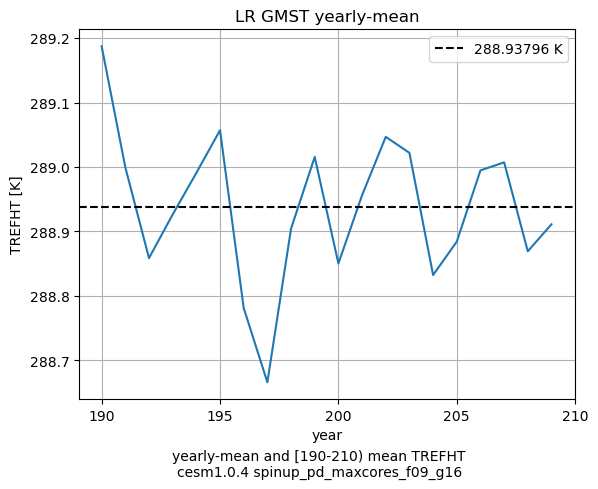

In [90]:
fig = plt.figure()
ax = fig.gca()
Tgm = dsya.TREFHT.isel(year=slice(0,-1)).weighted(dsya.gw).mean(('lat','lon'))
print(f"standard deviation: {Tgm.std('year'):.5} K")
Tgmtm = Tgm.mean('year')
Tgm.attrs.update({'units':'K'})
Tgm.plot(ax=ax)
ax.axhline(Tgmtm, linestyle='--', color='k', label=f"{Tgmtm.data:.5f} K")
plt.legend()
plt.xticks(range(190,211,5))
plt.grid()
plt.title('LR GMST yearly-mean')
fig.text(0.5, -0.05, 'yearly-mean and [190-210) mean TREFHT\ncesm1.0.4 spinup_pd_maxcores_f09_g16', ha='center')
fig.savefig("LR_GMST_YRLYMEAN.pdf", dpi=200)